In [502]:
import pandas as pd
import workdays
import datetime
# from datetime import datetime, timedelta, date
from xbbg import blp
import pdblp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator


In [503]:
def BDP(T,Fund,F,F1,F2,F3):
   
    T1 = [t + ' JP Equity' for t in T]   
    BDP = blp.bdp(tickers=T1, flds=F).loc[T1,:]
    BDP.columns = F1 + F2 + F3
    BDP = BDP.reset_index(drop=False)
    BDP['index'] = Fund

    for j in F2:
        BDP[j] = BDP[j].apply("{:,.0f}".format)
        
    for j in F3:
        BDP[j] = [round(x,2) for x in BDP[j].tolist()]
    
    return BDP
    

# T = ['03311187','0331418A','64315091','96311073','03312175','01313103','01314103']
# Fund = ['EM_SP','EM_オルカン','世界IDX','セゾン','EM_バランス','野村_普通','野村_積極']
T = ['0331418A','64315091','96311073','01313103','01314103','4731312A']
Fund = ['オルカン','世界IDX','セゾン','野村_普通','野村_積極','ソムリエ']
F = ['name_kanji','fund_incept_dt','fund_total_assets'] #'fund_comp_name'
F += ['volatility_360d','volatility_180d','current_trr_1yr','current_trr_6mo','current_trr_3mo','fund_mgr_stated_fee']

F1 = ['name','fund_incept_dt']
F2 = ['NAV']
F3 = ['vola_360d','vola_180d','trr_1yr','trr_6m','trr_3m','fee']

BDP = BDP(T,Fund,F,F1,F2,F3)
print(BDP.shape)
BDP

(6, 10)


,index,name,fund_incept_dt,NAV,vola_360d,vola_180d,trr_1yr,trr_6m,trr_3m,fee
0,オルカン,ｅＭＡＸＩＳ Ｓｌｉｍ 全世,2018-10-31,"2,270,546",16.03,12.96,28.93,10.20,11.58,0.10
1,世界IDX,世界経済ｲﾝﾃﾞｯｸｽﾌｧﾝﾄﾞ/SMTAM,2009-01-16,"256,198",10.76,9.44,19.16,6.60,6.78,0.50
2,セゾン,ｾｿﾞﾝ ｸﾞﾛｰﾊﾞﾙﾊﾞﾗﾝｽﾌｧﾝﾄﾞ,2007-03-15,"431,743",11.56,9.65,21.36,7.46,7.88,0.45
3,野村_普通,のむﾗｯﾌﾟﾌｧﾝﾄﾞ普通型/野村,2010-03-15,"335,567",9.84,8.16,15.20,6.35,7.20,1.23
4,野村_積極,のむﾗｯﾌﾟﾌｧﾝﾄﾞ積極型/野村,2010-03-15,"185,920",13.57,11.03,21.97,8.75,9.99,1.38
5,ソムリエ,投資のｿﾑﾘｴ/AMOne,2012-10-26,"414,446",3.70,3.71,-0.63,0.55,3.98,1.40


In [499]:

def BDH(T):
    T1 = [t + ' JP Equity' for t in T]  
    BDH = blp.bdh(T1, ['px_last','tot_return_index_gross_dvds'], d_from, d_to, Calendar='5D', Fill='P' ).reset_index()   
    
    df = pd.DataFrame(BDH['index'].values,columns = ['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    df = ME(df)
    tax = 0
    for i in range(len(T1)):
        df[Fund[i]+'_PR'] = BDH[T1[i]]['px_last'].pct_change()
        df[Fund[i]+'_GR'] = BDH[T1[i]]['tot_return_index_gross_dvds'].pct_change()
        df[Fund[i]+'_NR'] = (df[Fund[i]+'_GR'] - df[Fund[i]+'_PR'] ) * (1 - tax) + df[Fund[i]+'_PR']
        
    df = Adj(df)
        
    for i in range(len(T1)):
        for j in ['PR','GR','NR']:
            df[Fund[i]+'_'+j+'_Index'] = (1 + df[Fund[i]+'_'+j] ).cumprod().fillna(1) * 100

    return df


def Adj(df):
    tmp = df['世界IDX_PR'].first_valid_index()
    for j in ['PR','GR','NR']:
        df.loc[:tmp+5,'世界IDX_'+j] = df.loc[:tmp+5, 'セゾン_'+j].values
        
    tmp = ['MXWD Index','M2WD Index','USDJPY BGN Curncy','ES1 Index','TY1 Comdty','CO1 Comdty','GC1 Comdty']
    BDH1 = blp.bdh(tmp, ['px_last'], d_from, d_to, Calendar='5D', Fill='P' ).reset_index()
    BDH1.columns = ['Date'] + tmp
    BDH1['ACWI_PR'] = (BDH1['MXWD Index'] * BDH1['USDJPY BGN Curncy']).pct_change()
    BDH1['ACWI_GR'] = (BDH1['M2WD Index'] * BDH1['USDJPY BGN Curncy']).pct_change()
    BDH1['ACWI_NR'] = (BDH1['ACWI_GR'] - BDH1['ACWI_PR'] ) * (1 - 0.1) + BDH1['ACWI_GR']
    df = pd.concat([df, BDH1.iloc[:,1:]], axis=1)

    tmp = df['オルカン_PR'].first_valid_index()
    for j in ['PR','GR','NR']:
        df.loc[:tmp+5,'オルカン_'+j] = BDH1.loc[:tmp+5, 'ACWI_NR'].values
        
    tmp = ['USDJPY BGN Curncy','ES1 Index','TY1 Comdty','CO1 Comdty','GC1 Comdty']
    tmp1 = ['USDJPY','ES1','TY1','CO1','GC1']
    for j, j1 in zip(tmp, tmp1):
        df[j1+'_GR'] = BDH1[j].pct_change()
        df[j1+'_GR_Index'] = (1 + df[j1+'_GR'] ).cumprod().fillna(1) * 100

    # df['ES1_GR'] = df['ES1 Index'].pct_change()
    # df['ES1_GR_Index'] = (1 + df['ES1_GR'] ).cumprod().fillna(1) * 100
        
    return df

def ME(df):
    df['ME'] = 0
    tmp = df['Date'].dt.month != df['Date'].shift(-1).dt.month
    df['ME'] = np.where(tmp & (df['Date'].dt.month == 3), 3, np.where(tmp, 1, 0))
    df.loc[len(df)-1, 'ME'] = 3
    return df

In [500]:
d_from = '20070330'
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime('%Y%m%d')
df = BDH(T)

In [487]:
def Ret(k,L,df):
    L_index = [x + "_GR_Index" for x in L]
    tmp = df.loc[df["ME"]>=k,["Date"]+[x for x in L_index]].copy()
    tmp[L] = tmp[L_index].pct_change()
    tmp = tmp.iloc[1:].reset_index(drop=True)    
    return tmp[["Date"]+L]

def Percent(tmp):
    tmp.iloc[:, 1:] = tmp.iloc[:, 1:].applymap(lambda x: f"{x:.1%}")
    return tmp

def Corr(k,L,df):
    L_Index = [x + "_GR_Index" for x in L]
    tmp = df.loc[df["ME"]>=k,["Date"]+L_Index]
    tmp[L] =  tmp[L_Index].pct_change().iloc[1:]
    tmp = tmp[L].corr().applymap("{:.2f}".format)
        
    return tmp.replace("1.00", "-")


In [501]:
L = ['オルカン','セゾン','世界IDX','USDJPY','ES1','TY1','CO1','GC1']
Percent(Ret(3,L,df))


,Date,オルカン,セゾン,世界IDX,USDJPY,ES1,TY1,CO1,GC1
0,2008-03-31,-14.1%,-9.3%,-9.3%,-15.4%,-10.0%,12.4%,55.2%,31.3%
1,2009-03-31,-41.5%,-24.6%,-24.8%,-0.7%,-39.8%,10.0%,-65.2%,-1.7%
2,2010-03-31,51.3%,18.4%,27.8%,-5.5%,49.1%,-1.8%,39.9%,19.6%
3,2011-03-31,4.3%,-2.7%,-1.0%,-11.1%,15.2%,5.6%,37.8%,28.1%
4,2012-03-30,2.1%,1.5%,-0.8%,-0.3%,8.2%,11.7%,22.1%,15.3%
5,2013-03-29,29.7%,19.9%,20.6%,13.7%,13.3%,4.8%,0.1%,-5.3%
6,2014-03-31,31.4%,18.5%,14.4%,9.6%,21.1%,-2.7%,3.8%,-19.8%
7,2015-03-31,26.1%,17.2%,15.4%,16.4%,12.2%,6.5%,-53.0%,-8.1%
8,2016-03-31,-7.8%,-6.0%,-8.8%,-6.3%,1.3%,2.9%,-40.0%,4.1%
9,2017-03-31,17.2%,4.8%,6.5%,-1.0%,16.3%,-2.8%,19.4%,-0.3%


In [340]:
tmp = Corr(1,L,df)
print("Correlation")
tmp

Correlation


,オルカン,セゾン,世界IDX,USDJPY,ES1
オルカン,-,0.93,0.95,0.53,0.85
セゾン,0.93,-,0.97,0.59,0.73
世界IDX,0.95,0.97,-,0.54,0.76
USDJPY,0.53,0.59,0.54,-,0.09
ES1,0.85,0.73,0.76,0.09,-


In [344]:
def SD(k,L,Sort,df):
    
    L_Index = [x + "_GR_Index" for x in L]
    tmp = df.loc[df["ME"]>=k,["Date"]+L_Index].copy().reset_index(drop=True)
    # tmp = tmp.loc[r_from:,:].reset_index(drop=True)
    
    Year = (max(tmp["Date"]) -  min(tmp["Date"])).days/365.25

    Ret =  tmp.loc[len(tmp)-1,L_Index] / tmp.loc[0,L_Index]
    Ret =  Ret**(1/Year) - 1
    
    tmp[L] = tmp[L_Index].pct_change()
    tmp = tmp.iloc[1:].reset_index(drop=True)
    tmp = np.std(tmp[L]) * 12**0.5

    SD = pd.DataFrame({
        "Name": L,
        "Ret": Ret.values,
        "SD": tmp.values    })
    
    SD["Ratio"] = SD["Ret"] / SD["SD"]
    if Sort != "":
        SD = SD.sort_values(Sort, ascending=False).reset_index(drop=True)
    
    return SD


def Format(tmp):
    tmp["Ret"] = tmp["Ret"].apply("{:.2%}".format)
    tmp["SD"] = tmp["SD"].apply("{:.2%}".format)
    tmp["Ratio"] = tmp["Ratio"].apply("{:.2f}".format)
    return tmp

tmp = Format(SD(1,L,"Ratio",df))
print("SD",tmp.shape)
tmp

SD (5, 4)


,Name,Ret,SD,Ratio
0,オルカン,9.78%,19.15%,0.51
1,ES1,8.06%,16.02%,0.50
2,セゾン,5.07%,12.00%,0.42
3,世界IDX,4.83%,12.74%,0.38
4,USDJPY,1.38%,9.69%,0.14


In [451]:
def to_percent(y, position):
    return "{:.0f}%".format(100 * y)

def Plot(method=''):
    df1 = df.loc[(df['Date'] >= d_start) & (df['Date'] <= d_end ),:].reset_index()
    fig, ax = plt.subplots(figsize=(7.5, 2))
    for l in L:
        
        if method == 'DD':
            tmp = df1[l+'_GR_Index'] / df1[l+'_GR_Index'].cummax() - 1
        else:
            tmp = df1[l+'_GR_Index'] / df1.loc[0,l+'_GR_Index'] - 1
    
        ax.plot(df1["Date"], tmp, label=l, linewidth=0.5 )

    ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval ))
    # ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    if axhline != "":
        ax.axhline(y=axhline, color='gray', linestyle='--', linewidth=0.5)

    ax.set_title(title, fontsize=10)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.show()

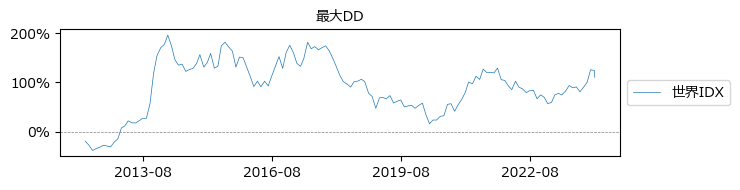

In [547]:
k = 1
L = ['オルカン']
t = 60

L_index = [x + "_GR_Index" for x in L]
tmp = df.loc[df["ME"]>=k,["Date"]+[x for x in L_index]].copy().reset_index(drop=True) 

tmp['Ret'] = tmp[L_index].pct_change(periods=t)

fig, ax = plt.subplots(figsize=(7.5, 2))
ax.plot(tmp['Date'], tmp['Ret'], label=l, linewidth=0.5 )

ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval ))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

ax.set_title(title, fontsize=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

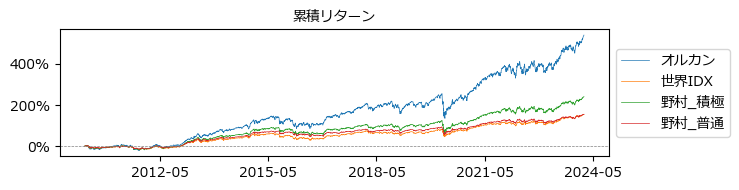

In [523]:
title = '累積リターン'
L = ['オルカン','世界IDX','野村_積極','野村_普通']
axhline = 0
d_start = '2010-3-31'
d_end = '2024-1-31'
# d_end = max(df['Date'])
x_interval = 36
Plot()

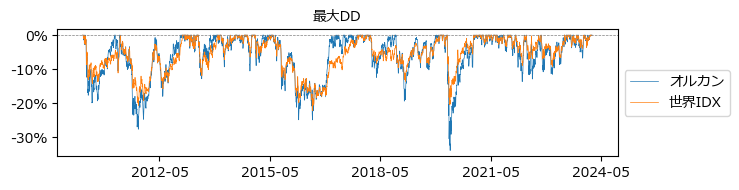

In [525]:
title = '最大DD'
L = ['オルカン','世界IDX']
axhline = 0
d_start = '2010-3-31'
d_end = '2024-1-31'
# d_end = max(df['Date'])
x_interval = 36
Plot('DD')

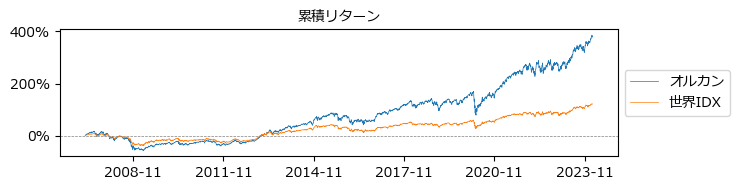

In [526]:
title = '累積リターン'
L = ['オルカン','世界IDX']
axhline = 0
d_start = '2007-3-30'
d_end = '2010-3-31'
d_end = max(df['Date'])
x_interval = 36

Plot()


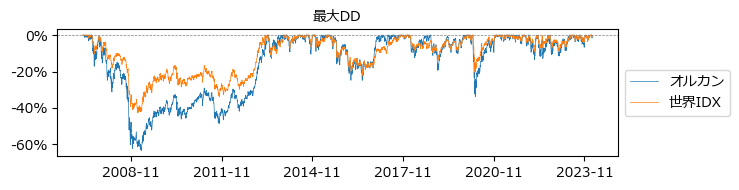

In [527]:
title = '最大DD'
L = ['オルカン','世界IDX']
axhline = 0
d_start = '2007-3-30'
d_end = '2010-3-31'
d_end = max(df['Date'])
x_interval = 36

Plot('DD')